# Actor–Critic A2C - Blackjack

*Proyecto RL 2024-2025 - Pablo Rodríguez Soria*

## 1. Importación de librerías y carga del entorno

In [11]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import utils
import math
import os
import pandas as pd

# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode=None)  # para entrenamiento (sin render)
n_actions = env.action_space.n
print("Acciones:", n_actions)

Acciones: 2


In [12]:
# Establecer la semilla para random y numpy
random.seed(42)  # Establece la semilla de random
np.random.seed(42)  # Establece la semilla de numpy

## 2. Hiperparámetros de Actor-Critic

In [13]:
gamma = 1  # Factor de descuento
episodes_train = 500_000  # Número de episodios de entrenamiento

# Learning rates a probar
g_lr_values = {
    'lr_alto': 1e-2,
    'lr_medio': 1e-3,
    'lr_bajo': 1e-4
}

## 3. Funciones auxiliares

In [14]:
def select_action(state, model):
    """
    Dada la política del actor, muestrear una acción y devolver log_prob.
    """
    state_t = torch.tensor(state, dtype=torch.float32)
    probs, value = model(state_t)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action), value


def compute_advantage(reward, next_value, current_value, done, gamma=0.99):
    """
    Calcula la ventaja A_t = r + γ V(s') – V(s),
    devolviéndola como tensor para poder encadenar backward().
    """
    # next_value y current_value ya son tensores
    if done:
        td_target = torch.tensor(reward, dtype=torch.float32)
    else:
        td_target = reward + gamma * next_value

    # Ventaja como tensor
    advantage = td_target - current_value.squeeze()
    return advantage


## 4. Definición del modelo Actor-Critic

In [16]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Red compartida
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        # Actor
        self.actor = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        # Crítico
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        h = self.shared(x)
        return self.actor(h), self.critic(h)

## 5. Entrenamiento de Actor-Critic

In [17]:
results = {}
models  = {}
for name, lr in g_lr_values.items():
    state_size = 3              # (player_sum, dealer_card, usable_ace)
    action_size = env.action_space.n  # 2 acciones: 0=Stick, 1=Hit
    model = ActorCritic(state_size, action_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_rewards = []

    for ep in range(episodes_train):
        state, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            # ---- Actor y Critic forward ----
            s_t = torch.tensor(state, dtype=torch.float32)
            probs, value = model(s_t)                         # value: tensor([v])
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()                            # acción escalar
            log_prob = dist.log_prob(action)                  # tensor escalar

            # ---- Interactuar con el entorno ----
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # ---- Critic forward en next_state ----
            s_tp1 = torch.tensor(next_state, dtype=torch.float32)
            _, next_value = model(s_tp1)                      # tensor([v'])

            # ---- Advantage como tensor ----
            # represéntalo como tensor para conservar grafo
            reward_t = torch.tensor([reward], dtype=torch.float32)
            A = reward_t + (0 if done else gamma * next_value) - value

            # ---- Pérdidas Actor y Critic ----
            actor_loss  = -log_prob * A.detach()               # solo gradiente w.r.t. actor
            critic_loss = 0.5 * A.pow(2)                       # A es tensor

            loss = (actor_loss + critic_loss).mean()

            # ---- Backprop y optimizador ----
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            ep_reward += reward

        total_rewards.append(ep_reward)
        if ep % 10000 == 0:
            print(f"{name} lr={lr}: Episodio {ep}/{episodes_train}, Recompensa {ep_reward:.2f}")

    results[name] = total_rewards
    models[name]  = model

lr_alto lr=0.01: Episodio 0/500000, Recompensa 1.00
lr_alto lr=0.01: Episodio 10000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 20000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 30000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 40000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 50000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 60000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 70000/500000, Recompensa 1.00
lr_alto lr=0.01: Episodio 80000/500000, Recompensa 1.00
lr_alto lr=0.01: Episodio 90000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 100000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 110000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 120000/500000, Recompensa 1.00
lr_alto lr=0.01: Episodio 130000/500000, Recompensa 1.00
lr_alto lr=0.01: Episodio 140000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 150000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 160000/500000, Recompensa -1.00
lr_alto lr=0.01: Episodio 170000/

## 6. Curvas de aprendizaje

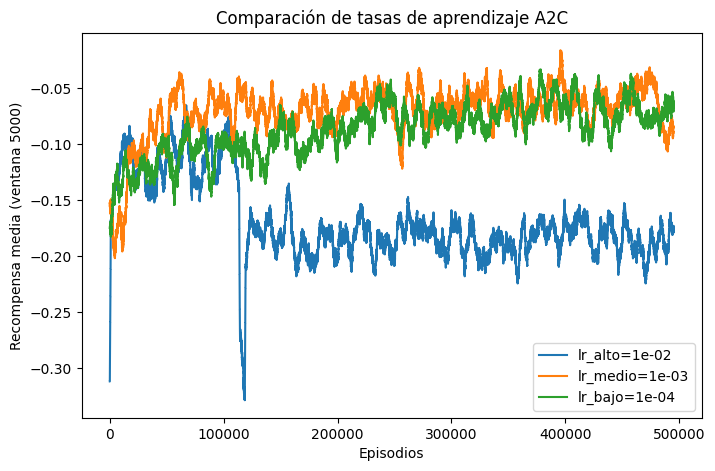

In [18]:
window = 5000
plt.figure(figsize=(8,5))

for name, rets in results.items():
    lr = g_lr_values[name]                              # obtenemos el valor real
    cumsum   = np.cumsum(rets)
    smoothed = (cumsum[window:] - cumsum[:-window]) / window
    plt.plot(smoothed, label=f"{name}={lr:.0e}")            # formateo en notación científica

plt.xlabel('Episodios')
plt.ylabel(f'Recompensa media (ventana {window})')
plt.title('Comparación de tasas de aprendizaje A2C')
plt.legend()
plt.show()


## 8. Evaluación en 10 000 episodios

In [19]:
def policy_ac2_fn(state):
    # Convertimos el estado a tensor y pedimos las probabilidades al actor
    s_t = torch.tensor(state, dtype=torch.float32)
    probs, _ = model(s_t)
    # Elegimos la acción con mayor probabilidad (stick=0, hit=1)
    return int(torch.argmax(probs).item())

def evaluate_with_std(policy_fn, n_episodes=10_000):
    wins = draws = losses = 0
    rewards = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        rewards.append(reward)
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

    # Proporciones
    p_w = wins / n_episodes
    p_d = draws / n_episodes
    p_l = losses / n_episodes

    # Desviaciones estándar para proporciones binomiales
    sigma_w = math.sqrt(p_w * (1 - p_w) / n_episodes)
    sigma_d = math.sqrt(p_d * (1 - p_d) / n_episodes)
    sigma_l = math.sqrt(p_l * (1 - p_l) / n_episodes)

    # Retorno medio y su desviación
    mean_ret = np.mean(rewards)
    sigma_ret = np.std(rewards)

    return (p_w, sigma_w,
            p_d, sigma_d,
            p_l, sigma_l,
            mean_ret, sigma_ret)

metrics = {}
for name, model in models.items():
    # definimos la política determinista a partir del actor
    def policy_fn(s, m=model):
        st = torch.tensor(s, dtype=torch.float32)
        probs, _ = m(st)
        return int(torch.argmax(probs).item())

    # evaluamos
    p_w, σ_w, p_d, σ_d, p_l, σ_l, avg_ret, σ_ret = evaluate_with_std(policy_fn, n_episodes=10_000)
    metrics[name] = {
        'ε':               name,
        'Victorias (%)':  (p_w*100, σ_w*100),
        'Empates (%)':    (p_d*100, σ_d*100),
        'Derrotas (%)':   (p_l*100, σ_l*100),
        'Retorno medio':  (avg_ret, σ_ret)
    }

# volcamos a DataFrame elegante
rows = []
for name, m in metrics.items():
    rows.append({
        'lr':                name,
        'Victorias (%)':     f"{m['Victorias (%)'][0]:.2f}±{m['Victorias (%)'][1]:.2f}",
        'Empates (%)':       f"{m['Empates (%)'][0]:.2f}±{m['Empates (%)'][1]:.2f}",
        'Derrotas (%)':      f"{m['Derrotas (%)'][0]:.2f}±{m['Derrotas (%)'][1]:.2f}",
        'Retorno medio':     f"{m['Retorno medio'][0]:.3f}±{m['Retorno medio'][1]:.3f}",
    })
df = pd.DataFrame(rows).set_index('lr')
display(df)

,Victorias (%),Empates (%),Derrotas (%),Retorno medio
lr,,,,
lr_alto,37.44±0.48,4.70±0.21,57.86±0.49,-0.204±0.955
lr_medio,42.82±0.49,7.31±0.26,49.87±0.50,-0.070±0.960
lr_bajo,43.63±0.50,8.72±0.28,47.65±0.50,-0.040±0.955


In [20]:
# Guardar el mejor modelo entrenado
# elegir etiqueta cuyo retorno medio sea máximo
best_tag = max(metrics.items(), key=lambda x: x[1]['Retorno medio'][0])[0]
best_model = models[best_tag]
print(f"Mejor lr = {best_tag}, Retorno medio = {metrics[best_tag]['Retorno medio'][0]:.3f}")

filename = f"../data/models/ac2_best_{best_tag}.pt"
os.makedirs("../data/models", exist_ok=True)  # Crea la carpeta si no existe
torch.save(best_model.state_dict(), filename)  # Guardar el modelo
print("Modelo guardado en ", filename)

Mejor lr = lr_bajo, Retorno medio = -0.040
Modelo guardado en  ../data/models/ac2_best_lr_bajo.pt


## 7. Mapa de calor de la política aprendida

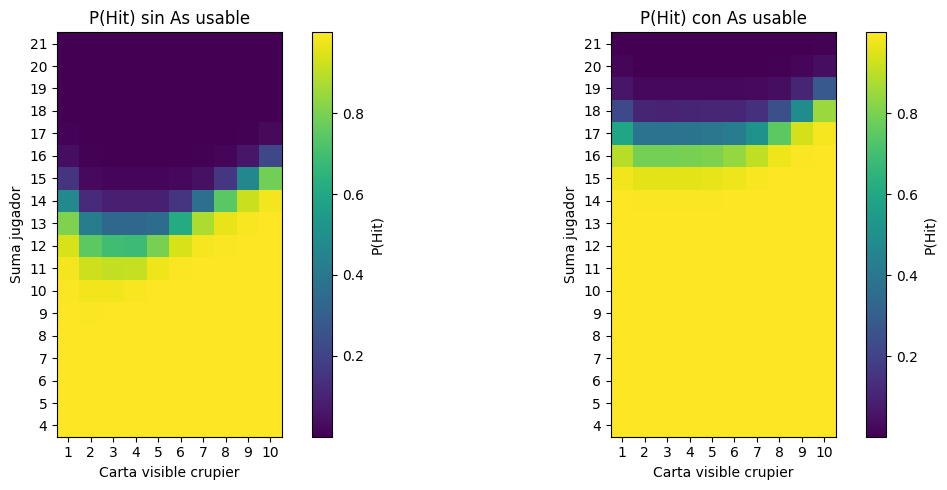

In [21]:
# 1) Crear las dos matrices vacías
policy_no_ace = np.zeros((22,10))
policy_ace    = np.zeros((22,10))

# 2) Rellenarlas usando best_model
for player in range(4,22):
    for dealer in range(1,11):
        for ace in [False, True]:
            # Preparamos tensor de estado
            s = torch.tensor([player, dealer, int(ace)], dtype=torch.float32)
            probs, _ = best_model(s)         # Paso por el actor del mejor modelo
            p_hit = probs[1].item()          # Probabilidad de "Hit"

            # Mapear a la matriz correspondiente
            if ace:
                policy_ace[player, dealer-1] = p_hit
            else:
                policy_no_ace[player, dealer-1] = p_hit

# 3) Dibujar los mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sin As usable
im0 = axes[0].imshow(policy_no_ace[4:], origin='lower', cmap='viridis')
axes[0].set_title('P(Hit) sin As usable')
axes[0].set_xlabel('Carta visible crupier')
axes[0].set_xticks(range(10));  axes[0].set_xticklabels(range(1,11))
axes[0].set_ylabel('Suma jugador')
axes[0].set_yticks(range(18));  axes[0].set_yticklabels(range(4,22))

# Con As usable
im1 = axes[1].imshow(policy_ace[4:], origin='lower', cmap='viridis')
axes[1].set_title('P(Hit) con As usable')
axes[1].set_xlabel('Carta visible crupier')
axes[1].set_xticks(range(10));  axes[1].set_xticklabels(range(1,11))
axes[1].set_ylabel('Suma jugador')
axes[1].set_yticks(range(18));  axes[1].set_yticklabels(range(4,22))

# Colorbars
plt.colorbar(im0, ax=axes[0], label='P(Hit)')
plt.colorbar(im1, ax=axes[1], label='P(Hit)')

plt.tight_layout()
plt.show()

## 9. Demostración visual de la política

Recompensa episodio: -1.0


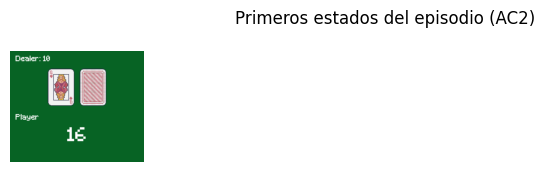

In [22]:
# 1. Crear el entorno con renderizado RGB
env_vis = gym.make("Blackjack-v1", render_mode="rgb_array")

# 2. Ejecutar un episodio usando la política AC2
frames, total_reward = utils.run_and_render_episode(env_vis, policy_ac2_fn)

# 3. Imprimir la recompensa total del episodio
print("Recompensa episodio:", total_reward)

# 4. Mostrar los primeros 5 frames como imágenes estáticas
plt.figure(figsize=(10, 2))
for i in range(min(5, len(frames))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[i])
    plt.axis('off')
plt.suptitle('Primeros estados del episodio (AC2)')
plt.show()
